In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path
from flygym import Fly, Camera, SingleFlySimulation
from tqdm import tqdm, trange
from flygym.examples.common import PreprogrammedSteps
from flygym.examples.rule_based_controller import (
    construct_rules_graph,
    RuleBasedSteppingCoordinator,
)

import imageio
import cv2

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
# Initialize simulation
run_time = 1
out_dir = Path("../decentralized_ctrl")

enable_adhesion = True

fly = Fly(
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right",
    fps=30,
    play_speed=0.1,
    window_size=(700, 560),
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
)

In [4]:
num_steps_base = int(run_time / sim.timestep)

# Run the simulation for a few steps to stabilise the system before starting the contoller
n_stabilisation_steps = 2000
num_steps = num_steps_base + n_stabilisation_steps

In [5]:
# Define rule variables
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]

In [6]:
preprogrammed_steps = PreprogrammedSteps()

# Initialize rule-based controller
weights = {
    "rule1": -10,
    "rule2_ipsi": 2.5,
    "rule2_contra": 1,
    "rule3_ipsi": 3.0,
    "rule3_contra": 2.0,
}
rules_graph = construct_rules_graph()
controller = RuleBasedSteppingCoordinator(
    timestep=sim.timestep,
    rules_graph=rules_graph,
    weights=weights,
    preprogrammed_steps=preprogrammed_steps,
    seed=42,
)

In [7]:
# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

obs_list_cruse_flat = []
all_initiated_legs = []

prev_mask_is_stepping = np.zeros(len(legs), dtype=bool)

In [8]:
sim.reset()

# Run the actual simulation
for i in trange(num_steps):
    controller.step()

    is_new_stepping = ~prev_mask_is_stepping & controller.mask_is_stepping
    prev_mask_is_stepping[:] = controller.mask_is_stepping

    if is_new_stepping.any():
        for leg in np.where(is_new_stepping)[0]:
            all_initiated_legs.append((leg, i))

    joint_angles = []
    adhesion_onoff = []

    for leg, phase in zip(controller.legs, controller.leg_phases):
        joint_angles_arr = controller.preprogrammed_steps.get_joint_angles(leg, phase)
        joint_angles.append(joint_angles_arr.flatten())
        adhesion_onoff.append(
            controller.preprogrammed_steps.get_adhesion_onoff(leg, phase)
        )

    action = {
        "joints": np.concatenate(joint_angles),
        "adhesion": np.array(adhesion_onoff),
    }
    obs_list_cruse_flat.append(sim.step(action)[0])
    render_img = sim.render()

    all_legs_rule1_scores[:, i] = controller.rule1_scores
    all_legs_rule2_scores[:, i] = controller.rule2_scores
    all_legs_rule3_scores[:, i] = controller.rule3_scores
    all_leg_scores[:, i] = controller.combined_scores

cam.save_video(
    "outputs/rule_based.mp4", stabilization_time=n_stabilisation_steps * sim.timestep
)
sim.close()

distances = (
    obs_list_cruse_flat[n_stabilisation_steps]["fly"][0][:2]
    - obs_list_cruse_flat[-1]["fly"][0][:2]
)
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [00:21<00:00, 558.77it/s]
[swscaler @ 0x6e07c00] Warning: data is not aligned! This can lead to a speed loss


Forward distance travelled:  -6.6130133
Lateral distance travelled:  1.522509


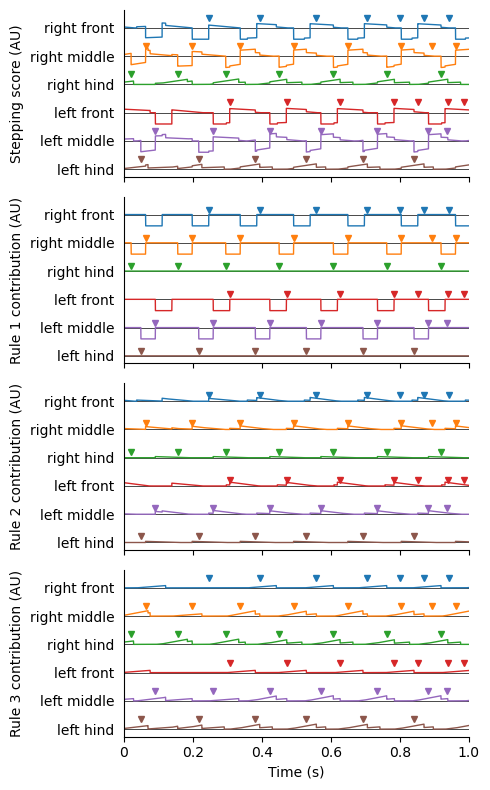

In [9]:
scores = {
    "Stepping score": all_leg_scores[:, n_stabilisation_steps:],
    "Rule 1 contribution": all_legs_rule1_scores[:, n_stabilisation_steps:],
    "Rule 2 contribution": all_legs_rule2_scores[:, n_stabilisation_steps:],
    "Rule 3 contribution": all_legs_rule3_scores[:, n_stabilisation_steps:],
}
time = np.arange(scores["Stepping score"].shape[1]) * sim.timestep
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}
leg_basey_lookup = {
    "right front": 0,
    "right middle": -1,
    "right hind": -2,
    "left front": -3,
    "left middle": -4,
    "left hind": -5,
}
leg_name_lookup = {
    "RF": "right front",
    "LF": "left front",
    "RM": "right middle",
    "LM": "left middle",
    "RH": "right hind",
    "LH": "left hind",
}


def plot_frame(current_time=None, video_layout=False, spacing=25):
    if video_layout:
        fig, axs = plt.subplots(
            2, 2, figsize=(10, 4), sharex=True, sharey=True, tight_layout=True
        )
    else:
        fig, axs = plt.subplots(
            4, 1, figsize=(5, 8), sharex=True, sharey=True, tight_layout=True
        )
    for i, (score_name, score_ts) in enumerate(scores.items()):
        ax = axs.flatten()[i]
        for j, leg in enumerate(legs):
            offset = leg_basey_lookup[leg_name_lookup[leg]] * spacing
            ax.plot(
                time,
                score_ts[j, :] + offset,
                label=leg,
                color=color_lookup[leg],
                linewidth=1,
            )
            ax.axhline(offset, color="k", linestyle="-", linewidth=0.5, zorder=-1)
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * spacing)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
        ax.set_xlim(0, 1)
        ax.set_ylabel(f"{score_name} (AU)")
        if video_layout:
            ax.set_title(score_name)
        if i == 3 or (i == 2 and video_layout):
            ax.set_xlabel("Time (s)")
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])

        for leg_index, step in all_initiated_legs:
            leg = legs[leg_index]
            step_time = time[step - n_stabilisation_steps]
            marker_heihgt = score_ts[j, :].max() + 4000 / 23000 * spacing
            offset = leg_basey_lookup[leg_name_lookup[leg]] * spacing
            ax.plot(
                step_time,
                offset + marker_heihgt,
                "v",
                color=color_lookup[leg],
                zorder=10,
                markersize=5,
            )
        ax.tick_params(left=False)

        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)

    sns.despine()
    return fig


plt.style.use("default")
fig = plot_frame()
fig.savefig("outputs/rule_based.pdf", transparent=True)

In [10]:
plt.style.use("dark_background")

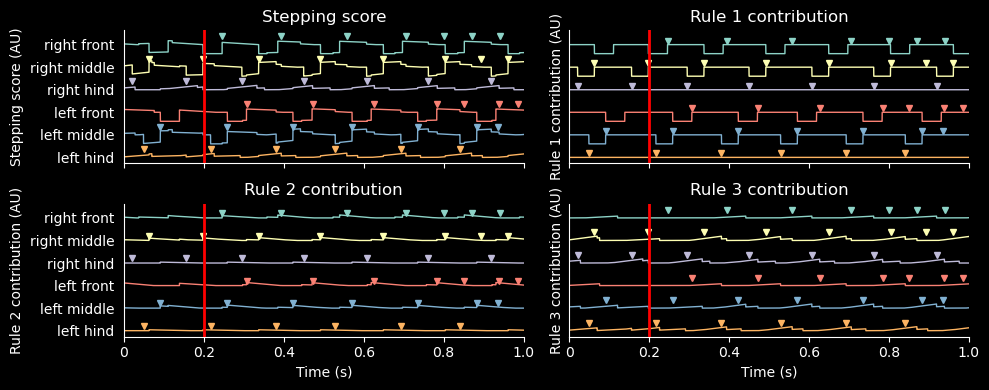

In [11]:
fig = plot_frame(current_time=0.2, video_layout=True)

In [12]:
def matplotlib_figure_to_array(fig):
    """Adapted from https://stackoverflow.com/a/67823421/13560623"""
    with io.BytesIO() as buff:
        fig.savefig(buff, format="raw")
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    return data.reshape((int(h), int(w), -1))

In [13]:
def merge_frame_and_time_series(i, frame):
    current_time = i * cam._eff_render_interval
    time_series_fig = plot_frame(current_time, video_layout=True)
    time_series_img = matplotlib_figure_to_array(time_series_fig)
    plt.close(fig=time_series_fig)

    assert frame.shape[0] >= time_series_img.shape[0]

    width = frame.shape[1]
    ts_height = int(width * time_series_img.shape[0] / time_series_img.shape[1])
    time_series_img = cv2.resize(time_series_img, (width, ts_height))
    merged_frame = np.concatenate([frame[:, :, :3], time_series_img[:, :, :3]], axis=0)
    return merged_frame

In [14]:
n_frames_to_drop = int(n_stabilisation_steps * sim.timestep / cam._eff_render_interval)
frames_to_render = cam._frames[n_frames_to_drop:]
video_shape = merge_frame_and_time_series(0, frames_to_render[0]).shape

out = imageio.get_writer("outputs/rule_based.mp4", fps=cam.fps)

for i, frame in tqdm(enumerate(frames_to_render), total=len(frames_to_render)):
    merged_frame = merge_frame_and_time_series(i, frame)
    # out.write(merged_frame[:, :, ::-1])  # RGB to BGR
    out.append_data(merged_frame)

out.close()

100%|██████████| 300/300 [00:51<00:00,  5.88it/s]
